<a href="https://colab.research.google.com/github/shuang379/CNN_based_car_classification/blob/main/car_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Based Car Classification  

**Table of content:**  
1. Prepare data
2. Define classes and functions
3. Train models
4. Test models

## Check GPU

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=fee0ed669390e6787e80f44652d965c5677c9c9c8b1112563c057f083666d409
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 111.6 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


# 1. Prepare data
Mount Google drive to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display

from textwrap import wrap, fill

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


## 1.1 Data transform

In [ ]:
dataset_dir = '/content/drive/My Drive/car_classification/car_data/'

batch_size = 32
valid_size = 0.2
num_workers = 2
width, height = 224, 224

train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 torchvision.transforms.RandomAffine(10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# create datasets
train_data = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform=train_tfms)
test_data = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)

num_train = len(test_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
valid_idx, test_idx = indices[:split], indices[split:]

valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

print('Train data size: ', len(train_data))
print('Validation data size: ', len(valid_idx))
print('Test data size: ', len(test_idx))

Train data size:  8144
Validation data size:  1608
Test data size:  6433


## 1.2 Visualize a batch of training data

In [ ]:
# tie the class indices to their names
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, c_to_idx = find_classes(dataset_dir+"train")

In [ ]:
%matplotlib inline

# inverse normalization for display purpose
inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                     std=[1/0.229, 1/0.224, 1/0.225])

def display_images(images, labels, size):
    cols = 8
    rows = size // cols
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 10), constrained_layout=True)
    plt.setp(axes, xticks=[], yticks=[])
    for a, b in enumerate(axes.flat):
        image = inv_normalize(images[a]).permute(1,2,0).numpy()
        image[image < 0] = 0
        image[image > 1] = 1
        b.imshow(image)
        b.set_title("\n".join(wrap(classes[labels[a]], 16)))

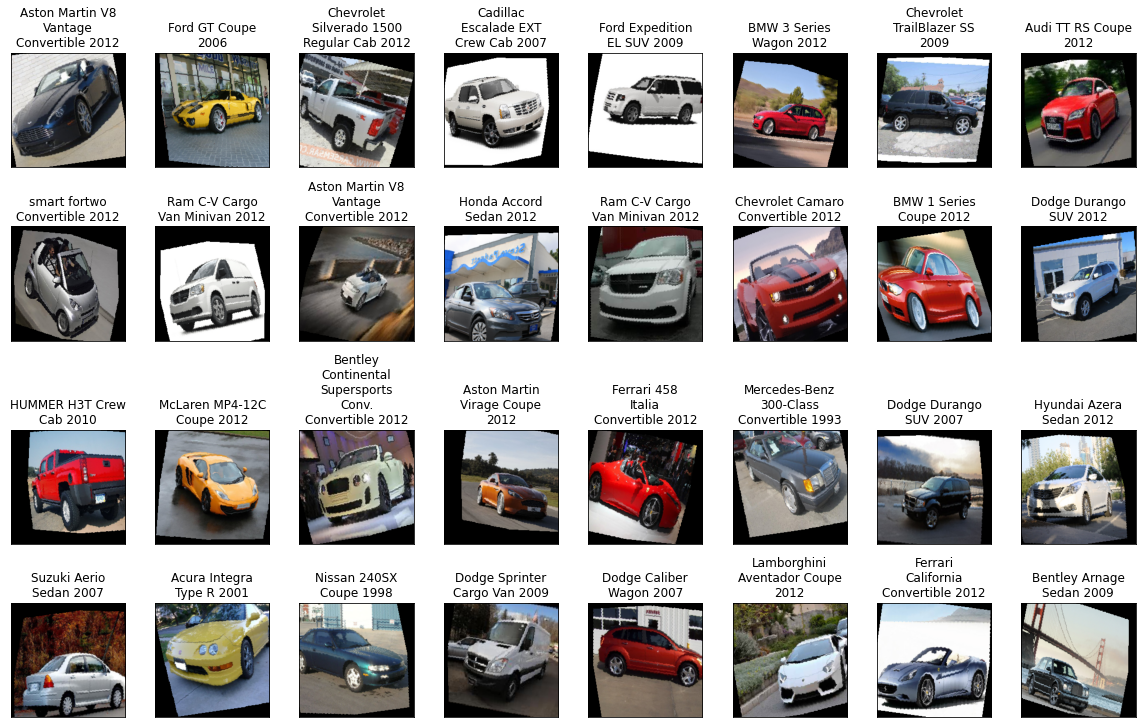

In [ ]:
# obtain one batch of training images
train_iter = iter(train_loader)
images, labels = train_iter.next()

display_images(images, labels, batch_size)

# 2. Define classes and functions
## 2.1 Eearly stopping class

In [ ]:
"""
Credit to: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d 
"""
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

## 2.2 Model training function

Here we train our model, after each epoch, we test the model on the validation data to see how it's going

In [ ]:
def train_model(model, criterion, optimizer, scheduler, model_name, n_epochs=5, patience=10):
    
    losses = []
    accuracies = []
    valid_accuracies = []
    valid_losses = []
    valid_arr_max = -np.inf
    
    es = EarlyStopping(patience=patience)

    # set the model to train mode initially
    model.train()
    for epoch in tqdm.tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step() # update weights
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 1 / 32 * running_correct / len(train_loader)
        print("Epoch {}, duration: {}s, loss: {:.3f}, acc: {:.3f}".format(epoch+1, int(epoch_duration), epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        valid_acc, valid_loss = eval_model(model, criterion, 'valid')
            
        valid_accuracies.append(valid_acc)
        valid_losses.append(valid_loss)
        if valid_acc > valid_arr_max:
            print('Validation accuracy increased ({:.3f} --> {:.3f}).  Saving model ...'.format(valid_arr_max, valid_acc))
            torch.save(model.state_dict(), model_name)
            valid_arr_max = valid_acc
        else:
            print('Validation accuracy did not improve from {:3f}.'.format(valid_arr_max))
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(valid_acc)
        since = time.time()
        
        # early stopping
        if es.step(valid_acc):
            print('Early stopping ...')
            break
            
    print('Finished Training')
    return model, losses, accuracies, valid_losses, valid_accuracies

## 2.3 Function for evaluation and test
This function is called out after each epoch of training on the validation data. We then measure the accuracy of the model.

In [ ]:
def eval_model(model, criterion, mode='valid'):
    correct = 0.0
    total = 0.0
    loss = 0.0
    
    model.eval()
    if mode == 'valid':
        data_loader = valid_loader
    elif mode == 'test':
        data_loader = test_loader
    
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_acc = 1.0 * correct / total
    if mode == 'valid':
        print('Accuracy of the network on the validation images: {:.3f} ({}/{})'.format(valid_acc, int(correct), int(total)))
    else:
        print('Accuracy of the network on the test images: {:.3f} ({}/{})'.format(valid_acc, int(correct), int(total)))
        
    model.train()
    return valid_acc, loss

## 2.4 Learning curve plotting function

In [ ]:
def plot_learning_curves(training_loss, training_acc, valid_loss, valid_acc):
    plt.figure(figsize=(12, 4))
    legends = ['Training', 'Validation']
    
    plt.subplot(1,2,1)
    plt.plot(training_loss)
    plt.plot(valid_loss)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(training_loss), 2))
    plt.legend(legends, loc='best')
    
    plt.subplot(1,2,2)
    plt.plot(training_acc)
    plt.plot(valid_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(valid_loss), 2))
    plt.legend(legends, loc='best')
    
    plt.tight_layout()
    
    return

# 3. Train models
## 3.1 Alexnet

In [ ]:
NUM_CAR_CLASSES = 196
alexnet = models.alexnet(pretrained=True)

# Freezing parameters in features layers
# for param in alexnet.features.parameters():
#     param.require_grad = False

# replace the last fc layer with an untrained one (requires grad by default)
n_inputs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(n_inputs, NUM_CAR_CLASSES)

# put model on GPU
alexnet = alexnet.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by at least 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
"""
lrscheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
alexnet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=196, bias=True)
)

In [ ]:
alexnet, trainLoss1, trainAcc1, validLoss1, validAcc1 = train_model(alexnet, criterion, optimizer1, 
                                                                    lrscheduler1, 'alexnet_model.pt', n_epochs=40)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1, duration: 895s, loss: 5.263, acc: 0.009
Accuracy of the network on the validation images: 0.019 (30/1608)
Validation accuracy increased (-inf --> 0.019).  Saving model ...


  2%|▎         | 1/40 [17:55<11:39:06, 1075.54s/it]

Epoch 2, duration: 91s, loss: 5.073, acc: 0.027
Accuracy of the network on the validation images: 0.045 (73/1608)
Validation accuracy increased (0.019 --> 0.045).  Saving model ...


  5%|▌         | 2/40 [19:45<8:17:38, 785.76s/it]  

Epoch 3, duration: 90s, loss: 4.676, acc: 0.053
Accuracy of the network on the validation images: 0.087 (140/1608)
Validation accuracy increased (0.045 --> 0.087).  Saving model ...


  8%|▊         | 3/40 [21:34<5:59:23, 582.81s/it]

Epoch 4, duration: 91s, loss: 4.322, acc: 0.088
Accuracy of the network on the validation images: 0.103 (165/1608)
Validation accuracy increased (0.087 --> 0.103).  Saving model ...


 10%|█         | 4/40 [23:23<4:24:30, 440.84s/it]

Epoch 5, duration: 91s, loss: 4.027, acc: 0.118
Accuracy of the network on the validation images: 0.117 (188/1608)
Validation accuracy increased (0.103 --> 0.117).  Saving model ...


 12%|█▎        | 5/40 [25:12<3:19:04, 341.27s/it]

Epoch 6, duration: 91s, loss: 3.822, acc: 0.144
Accuracy of the network on the validation images: 0.160 (257/1608)
Validation accuracy increased (0.117 --> 0.160).  Saving model ...


 15%|█▌        | 6/40 [27:02<2:34:01, 271.82s/it]

Epoch 7, duration: 92s, loss: 3.652, acc: 0.179


 18%|█▊        | 7/40 [28:52<2:02:50, 223.35s/it]

Accuracy of the network on the validation images: 0.152 (245/1608)
Validation accuracy did not improve from 0.159826.
Epoch 8, duration: 91s, loss: 2.770, acc: 0.315
Accuracy of the network on the validation images: 0.300 (482/1608)
Validation accuracy increased (0.160 --> 0.300).  Saving model ...


 20%|██        | 8/40 [30:41<1:40:49, 189.04s/it]

Epoch 9, duration: 91s, loss: 2.321, acc: 0.398
Accuracy of the network on the validation images: 0.333 (536/1608)
Validation accuracy increased (0.300 --> 0.333).  Saving model ...


 22%|██▎       | 9/40 [32:31<1:25:20, 165.16s/it]

Epoch 10, duration: 92s, loss: 2.094, acc: 0.442
Accuracy of the network on the validation images: 0.353 (567/1608)
Validation accuracy increased (0.333 --> 0.353).  Saving model ...


 25%|██▌       | 10/40 [34:22<1:14:26, 148.87s/it]

Epoch 11, duration: 92s, loss: 1.909, acc: 0.484
Accuracy of the network on the validation images: 0.368 (592/1608)
Validation accuracy increased (0.353 --> 0.368).  Saving model ...


 28%|██▊       | 11/40 [36:12<1:06:18, 137.18s/it]

Epoch 12, duration: 91s, loss: 1.772, acc: 0.515
Accuracy of the network on the validation images: 0.373 (599/1608)
Validation accuracy increased (0.368 --> 0.373).  Saving model ...


 30%|███       | 12/40 [38:01<1:00:05, 128.76s/it]

Epoch 13, duration: 92s, loss: 1.506, acc: 0.578
Accuracy of the network on the validation images: 0.406 (653/1608)
Validation accuracy increased (0.373 --> 0.406).  Saving model ...


 32%|███▎      | 13/40 [39:51<55:25, 123.18s/it]  

Epoch 14, duration: 89s, loss: 1.463, acc: 0.586
Accuracy of the network on the validation images: 0.409 (658/1608)
Validation accuracy increased (0.406 --> 0.409).  Saving model ...


 35%|███▌      | 14/40 [41:39<51:23, 118.58s/it]

Epoch 15, duration: 91s, loss: 1.449, acc: 0.592


 38%|███▊      | 15/40 [43:28<48:15, 115.81s/it]

Accuracy of the network on the validation images: 0.409 (657/1608)
Validation accuracy did not improve from 0.409204.
Epoch 16, duration: 91s, loss: 1.392, acc: 0.603


 40%|████      | 16/40 [45:16<45:23, 113.47s/it]

Accuracy of the network on the validation images: 0.408 (656/1608)
Validation accuracy did not improve from 0.409204.
Epoch 17, duration: 91s, loss: 1.390, acc: 0.608
Accuracy of the network on the validation images: 0.410 (659/1608)
Validation accuracy increased (0.409 --> 0.410).  Saving model ...


 42%|████▎     | 17/40 [47:05<43:01, 112.24s/it]

Epoch 18, duration: 90s, loss: 1.376, acc: 0.605
Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy increased (0.410 --> 0.411).  Saving model ...


 45%|████▌     | 18/40 [48:54<40:43, 111.06s/it]

Epoch 19, duration: 91s, loss: 1.374, acc: 0.608


 48%|████▊     | 19/40 [50:42<38:32, 110.13s/it]

Accuracy of the network on the validation images: 0.410 (659/1608)
Validation accuracy did not improve from 0.411070.
Epoch 20, duration: 92s, loss: 1.369, acc: 0.609


 50%|█████     | 20/40 [52:31<36:40, 110.00s/it]

Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy did not improve from 0.411070.
Epoch 21, duration: 92s, loss: 1.361, acc: 0.616


 52%|█████▎    | 21/40 [54:21<34:48, 109.93s/it]

Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy did not improve from 0.411070.
Epoch 22, duration: 86s, loss: 1.380, acc: 0.615


 55%|█████▌    | 22/40 [56:05<32:23, 107.96s/it]

Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy did not improve from 0.411070.
Epoch 23, duration: 86s, loss: 1.365, acc: 0.615
Accuracy of the network on the validation images: 0.412 (662/1608)
Validation accuracy increased (0.411 --> 0.412).  Saving model ...


 57%|█████▊    | 23/40 [57:48<30:14, 106.74s/it]

Epoch 24, duration: 86s, loss: 1.372, acc: 0.609


 60%|██████    | 24/40 [59:31<28:06, 105.40s/it]

Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy did not improve from 0.411692.
Epoch 25, duration: 86s, loss: 1.395, acc: 0.606


 62%|██████▎   | 25/40 [1:01:14<26:09, 104.67s/it]

Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy did not improve from 0.411692.
Epoch 26, duration: 86s, loss: 1.370, acc: 0.616


 65%|██████▌   | 26/40 [1:02:57<24:18, 104.16s/it]

Accuracy of the network on the validation images: 0.412 (662/1608)
Validation accuracy did not improve from 0.411692.
Epoch 27, duration: 86s, loss: 1.365, acc: 0.609


 68%|██████▊   | 27/40 [1:04:39<22:28, 103.75s/it]

Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy did not improve from 0.411692.
Epoch 28, duration: 86s, loss: 1.353, acc: 0.618


 70%|███████   | 28/40 [1:06:22<20:40, 103.36s/it]

Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy did not improve from 0.411692.
Epoch 29, duration: 86s, loss: 1.382, acc: 0.608


 72%|███████▎  | 29/40 [1:08:04<18:54, 103.12s/it]

Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy did not improve from 0.411692.
Epoch 30, duration: 86s, loss: 1.383, acc: 0.610


 75%|███████▌  | 30/40 [1:09:47<17:08, 102.90s/it]

Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy did not improve from 0.411692.
Epoch 31, duration: 86s, loss: 1.373, acc: 0.605


 78%|███████▊  | 31/40 [1:11:30<15:26, 102.97s/it]

Accuracy of the network on the validation images: 0.411 (661/1608)
Validation accuracy did not improve from 0.411692.
Epoch 32, duration: 87s, loss: 1.378, acc: 0.604


 80%|████████  | 32/40 [1:13:13<13:44, 103.06s/it]

Accuracy of the network on the validation images: 0.412 (662/1608)
Validation accuracy did not improve from 0.411692.
Epoch 33, duration: 87s, loss: 1.380, acc: 0.609
Accuracy of the network on the validation images: 0.412 (662/1608)
Validation accuracy did not improve from 0.411692.
Early stopping ...
Finished Training


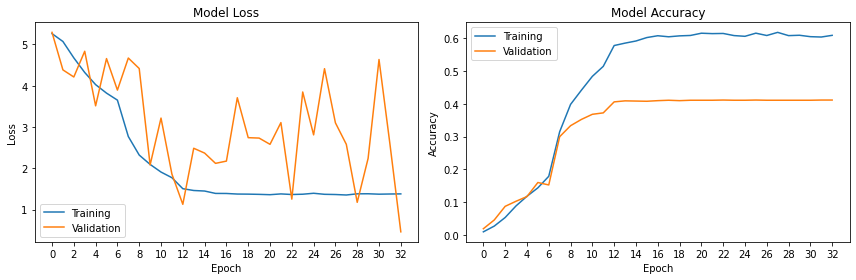

In [ ]:
plot_learning_curves(trainLoss1, trainAcc1, validLoss1, validAcc1)

## 3.2 VGG19

In [ ]:
NUM_CAR_CLASSES = 196
vgg19 = models.vgg19(pretrained=True)

# replace the last fc layer with an untrained one (requires grad by default)
n_inputs = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(n_inputs, NUM_CAR_CLASSES)

vgg19 = vgg19.to(device)

criterion = nn.CrossEntropyLoss()
optimizer3 = optim.SGD(vgg19.parameters(), lr=0.01, momentum=0.9)

lrscheduler3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer3, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
vgg19.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=196, bias=True)
)

In [ ]:
vgg19, trainLoss3, trainAcc3, validLoss3, validAcc3 = train_model(vgg19, criterion, optimizer3, 
                                                                    lrscheduler3, 'vgg19_model.pt', n_epochs=40)


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1, duration: 146s, loss: 5.282, acc: 0.005
Accuracy of the network on the validation images: 0.007 (12/1608)
Validation accuracy increased (-inf --> 0.007).  Saving model ...



  2%|▎         | 1/40 [02:48<1:49:33, 168.54s/it]

Epoch 2, duration: 147s, loss: 5.258, acc: 0.008
Accuracy of the network on the validation images: 0.009 (14/1608)
Validation accuracy increased (0.007 --> 0.009).  Saving model ...



  5%|▌         | 2/40 [05:37<1:46:48, 168.64s/it]

Epoch 3, duration: 146s, loss: 5.102, acc: 0.014
Accuracy of the network on the validation images: 0.029 (46/1608)
Validation accuracy increased (0.009 --> 0.029).  Saving model ...



  8%|▊         | 3/40 [08:25<1:43:53, 168.47s/it]

Epoch 4, duration: 146s, loss: 4.413, acc: 0.063
Accuracy of the network on the validation images: 0.123 (198/1608)
Validation accuracy increased (0.029 --> 0.123).  Saving model ...



 10%|█         | 4/40 [11:13<1:41:03, 168.44s/it]

Epoch 5, duration: 146s, loss: 3.618, acc: 0.144
Accuracy of the network on the validation images: 0.234 (376/1608)
Validation accuracy increased (0.123 --> 0.234).  Saving model ...



 12%|█▎        | 5/40 [14:01<1:38:09, 168.28s/it]

Epoch 6, duration: 146s, loss: 3.014, acc: 0.237
Accuracy of the network on the validation images: 0.307 (493/1608)
Validation accuracy increased (0.234 --> 0.307).  Saving model ...



 15%|█▌        | 6/40 [16:49<1:35:19, 168.22s/it]

Epoch 7, duration: 146s, loss: 2.551, acc: 0.330
Accuracy of the network on the validation images: 0.377 (606/1608)
Validation accuracy increased (0.307 --> 0.377).  Saving model ...



 18%|█▊        | 7/40 [19:37<1:32:23, 167.97s/it]

Epoch 8, duration: 146s, loss: 2.200, acc: 0.404
Accuracy of the network on the validation images: 0.497 (799/1608)
Validation accuracy increased (0.377 --> 0.497).  Saving model ...



 20%|██        | 8/40 [22:25<1:29:37, 168.04s/it]

Epoch 9, duration: 146s, loss: 1.914, acc: 0.471
Accuracy of the network on the validation images: 0.517 (832/1608)
Validation accuracy increased (0.497 --> 0.517).  Saving model ...



 22%|██▎       | 9/40 [25:13<1:26:45, 167.91s/it]

Epoch 10, duration: 145s, loss: 1.710, acc: 0.514
Accuracy of the network on the validation images: 0.581 (934/1608)
Validation accuracy increased (0.517 --> 0.581).  Saving model ...



 25%|██▌       | 10/40 [28:00<1:23:52, 167.74s/it]

Epoch 11, duration: 145s, loss: 0.886, acc: 0.726
Accuracy of the network on the validation images: 0.754 (1213/1608)
Validation accuracy increased (0.581 --> 0.754).  Saving model ...



 28%|██▊       | 11/40 [30:47<1:21:01, 167.65s/it]

Epoch 12, duration: 146s, loss: 0.670, acc: 0.786
Accuracy of the network on the validation images: 0.764 (1228/1608)
Validation accuracy increased (0.754 --> 0.764).  Saving model ...



 30%|███       | 12/40 [33:35<1:18:14, 167.66s/it]

Epoch 13, duration: 146s, loss: 0.590, acc: 0.813
Accuracy of the network on the validation images: 0.783 (1259/1608)
Validation accuracy increased (0.764 --> 0.783).  Saving model ...



 32%|███▎      | 13/40 [36:23<1:15:29, 167.75s/it]

Epoch 14, duration: 146s, loss: 0.529, acc: 0.827
Accuracy of the network on the validation images: 0.795 (1278/1608)
Validation accuracy increased (0.783 --> 0.795).  Saving model ...



 35%|███▌      | 14/40 [39:11<1:12:45, 167.90s/it]

Epoch 15, duration: 146s, loss: 0.465, acc: 0.842
Accuracy of the network on the validation images: 0.805 (1295/1608)
Validation accuracy increased (0.795 --> 0.805).  Saving model ...



 38%|███▊      | 15/40 [41:59<1:09:58, 167.96s/it]

Epoch 16, duration: 146s, loss: 0.416, acc: 0.858
Accuracy of the network on the validation images: 0.808 (1300/1608)
Validation accuracy increased (0.805 --> 0.808).  Saving model ...



 40%|████      | 16/40 [44:47<1:07:11, 168.00s/it]

Epoch 17, duration: 146s, loss: 0.398, acc: 0.866
Accuracy of the network on the validation images: 0.813 (1307/1608)
Validation accuracy increased (0.808 --> 0.813).  Saving model ...



 42%|████▎     | 17/40 [47:36<1:04:25, 168.05s/it]

Epoch 18, duration: 146s, loss: 0.377, acc: 0.871



 45%|████▌     | 18/40 [50:21<1:01:19, 167.23s/it]

Accuracy of the network on the validation images: 0.806 (1296/1608)
Validation accuracy did not improve from 0.812811.
Epoch 19, duration: 146s, loss: 0.385, acc: 0.867



 48%|████▊     | 19/40 [53:06<58:19, 166.63s/it]  

Accuracy of the network on the validation images: 0.812 (1305/1608)
Validation accuracy did not improve from 0.812811.
Epoch 20, duration: 146s, loss: 0.365, acc: 0.874



 50%|█████     | 20/40 [55:52<55:26, 166.30s/it]

Accuracy of the network on the validation images: 0.813 (1307/1608)
Validation accuracy did not improve from 0.812811.
Epoch 21, duration: 146s, loss: 0.361, acc: 0.881
Accuracy of the network on the validation images: 0.814 (1309/1608)
Validation accuracy increased (0.813 --> 0.814).  Saving model ...



 52%|█████▎    | 21/40 [58:40<52:49, 166.84s/it]

Epoch 22, duration: 146s, loss: 0.362, acc: 0.874



 55%|█████▌    | 22/40 [1:01:25<49:55, 166.42s/it]

Accuracy of the network on the validation images: 0.812 (1306/1608)
Validation accuracy did not improve from 0.814055.
Epoch 23, duration: 146s, loss: 0.364, acc: 0.876



 57%|█████▊    | 23/40 [1:04:11<47:03, 166.10s/it]

Accuracy of the network on the validation images: 0.812 (1306/1608)
Validation accuracy did not improve from 0.814055.
Epoch 24, duration: 146s, loss: 0.360, acc: 0.882



 60%|██████    | 24/40 [1:06:56<44:15, 165.95s/it]

Accuracy of the network on the validation images: 0.812 (1306/1608)
Validation accuracy did not improve from 0.814055.
Epoch 25, duration: 146s, loss: 0.365, acc: 0.876



 62%|██████▎   | 25/40 [1:09:41<41:25, 165.72s/it]

Accuracy of the network on the validation images: 0.812 (1306/1608)
Validation accuracy did not improve from 0.814055.
Epoch 26, duration: 146s, loss: 0.362, acc: 0.874



 65%|██████▌   | 26/40 [1:12:27<38:38, 165.61s/it]

Accuracy of the network on the validation images: 0.812 (1306/1608)
Validation accuracy did not improve from 0.814055.
Epoch 27, duration: 146s, loss: 0.365, acc: 0.874



 68%|██████▊   | 27/40 [1:15:12<35:52, 165.56s/it]

Accuracy of the network on the validation images: 0.812 (1306/1608)
Validation accuracy did not improve from 0.814055.
Epoch 28, duration: 146s, loss: 0.364, acc: 0.875



 70%|███████   | 28/40 [1:17:58<33:06, 165.52s/it]

Accuracy of the network on the validation images: 0.812 (1306/1608)
Validation accuracy did not improve from 0.814055.
Epoch 29, duration: 147s, loss: 0.366, acc: 0.877



 72%|███████▎  | 29/40 [1:20:44<30:24, 165.88s/it]

Accuracy of the network on the validation images: 0.812 (1306/1608)
Validation accuracy did not improve from 0.814055.
Epoch 30, duration: 146s, loss: 0.361, acc: 0.879



 75%|███████▌  | 30/40 [1:23:30<27:38, 165.85s/it]

Accuracy of the network on the validation images: 0.812 (1306/1608)
Validation accuracy did not improve from 0.814055.
Epoch 31, duration: 146s, loss: 0.365, acc: 0.875
Accuracy of the network on the validation images: 0.812 (1306/1608)
Validation accuracy did not improve from 0.814055.
Early stopping ...
Finished Training


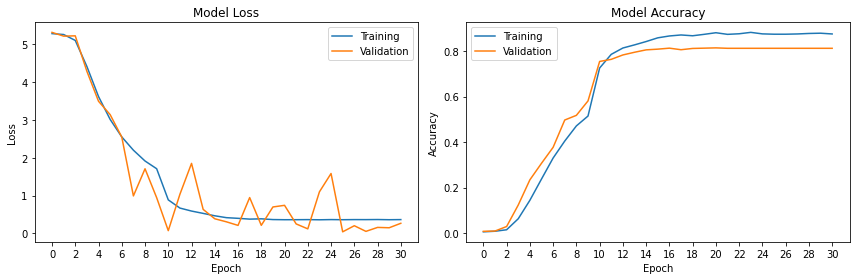

In [ ]:
plot_learning_curves(trainLoss3, trainAcc3, validLoss3, validAcc3)

## 3.3 Resnet34

In [ ]:
resnet34 = models.resnet34(pretrained=True)

# replace the last fc layer with an untrained one (requires grad by default)
num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

resnet34 = resnet34.to(device)

optimizer2 = optim.SGD(resnet34.parameters(), lr=0.01, momentum=0.9)

lrscheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
resnet34.fc

Linear(in_features=512, out_features=196, bias=True)

In [ ]:
resnet34, trainLoss2, trainAcc2, validLoss2, validAcc2 = train_model(resnet34, criterion, optimizer2, 
                                                                     lrscheduler2, 'resnet34_model.pt', n_epochs=40)



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1, duration: 98s, loss: 4.200, acc: 0.116




  2%|▎         | 1/40 [01:55<1:15:06, 115.55s/it]

Accuracy of the network on the validation images: 0.266 (428/1608)
Validation accuracy increased (-inf --> 0.266).  Saving model ...
Epoch 2, duration: 98s, loss: 2.350, acc: 0.373
Accuracy of the network on the validation images: 0.384 (617/1608)
Validation accuracy increased (0.266 --> 0.384).  Saving model ...




  5%|▌         | 2/40 [03:51<1:13:12, 115.60s/it]

Epoch 3, duration: 97s, loss: 1.590, acc: 0.553
Accuracy of the network on the validation images: 0.478 (769/1608)
Validation accuracy increased (0.384 --> 0.478).  Saving model ...




  8%|▊         | 3/40 [05:46<1:11:12, 115.47s/it]

Epoch 4, duration: 99s, loss: 1.157, acc: 0.665
Accuracy of the network on the validation images: 0.575 (925/1608)
Validation accuracy increased (0.478 --> 0.575).  Saving model ...




 10%|█         | 4/40 [07:43<1:09:30, 115.85s/it]

Epoch 5, duration: 99s, loss: 0.894, acc: 0.738
Accuracy of the network on the validation images: 0.626 (1007/1608)
Validation accuracy increased (0.575 --> 0.626).  Saving model ...




 12%|█▎        | 5/40 [09:40<1:07:49, 116.28s/it]

Epoch 6, duration: 99s, loss: 0.701, acc: 0.776
Accuracy of the network on the validation images: 0.659 (1059/1608)
Validation accuracy increased (0.626 --> 0.659).  Saving model ...




 15%|█▌        | 6/40 [11:37<1:06:00, 116.50s/it]

Epoch 7, duration: 98s, loss: 0.578, acc: 0.819
Accuracy of the network on the validation images: 0.705 (1134/1608)
Validation accuracy increased (0.659 --> 0.705).  Saving model ...




 18%|█▊        | 7/40 [13:33<1:03:55, 116.22s/it]

Epoch 8, duration: 99s, loss: 0.459, acc: 0.861
Accuracy of the network on the validation images: 0.715 (1150/1608)
Validation accuracy increased (0.705 --> 0.715).  Saving model ...




 20%|██        | 8/40 [15:29<1:02:05, 116.43s/it]

Epoch 9, duration: 99s, loss: 0.222, acc: 0.935
Accuracy of the network on the validation images: 0.820 (1319/1608)
Validation accuracy increased (0.715 --> 0.820).  Saving model ...




 22%|██▎       | 9/40 [17:27<1:00:15, 116.64s/it]

Epoch 10, duration: 99s, loss: 0.143, acc: 0.961
Accuracy of the network on the validation images: 0.831 (1337/1608)
Validation accuracy increased (0.820 --> 0.831).  Saving model ...




 25%|██▌       | 10/40 [19:23<58:19, 116.64s/it] 

Epoch 11, duration: 98s, loss: 0.116, acc: 0.970
Accuracy of the network on the validation images: 0.845 (1359/1608)
Validation accuracy increased (0.831 --> 0.845).  Saving model ...




 28%|██▊       | 11/40 [21:19<56:16, 116.45s/it]

Epoch 12, duration: 98s, loss: 0.107, acc: 0.972
Accuracy of the network on the validation images: 0.847 (1362/1608)
Validation accuracy increased (0.845 --> 0.847).  Saving model ...




 30%|███       | 12/40 [23:15<54:14, 116.23s/it]

Epoch 13, duration: 99s, loss: 0.094, acc: 0.975
Accuracy of the network on the validation images: 0.848 (1364/1608)
Validation accuracy increased (0.847 --> 0.848).  Saving model ...




 32%|███▎      | 13/40 [25:12<52:24, 116.47s/it]

Epoch 14, duration: 100s, loss: 0.091, acc: 0.977




 35%|███▌      | 14/40 [27:09<50:35, 116.76s/it]

Accuracy of the network on the validation images: 0.848 (1364/1608)
Validation accuracy did not improve from 0.848259.
Epoch 15, duration: 99s, loss: 0.095, acc: 0.976




 38%|███▊      | 15/40 [29:06<48:39, 116.77s/it]

Accuracy of the network on the validation images: 0.846 (1361/1608)
Validation accuracy did not improve from 0.848259.
Epoch 16, duration: 99s, loss: 0.089, acc: 0.977
Accuracy of the network on the validation images: 0.849 (1365/1608)
Validation accuracy increased (0.848 --> 0.849).  Saving model ...




 40%|████      | 16/40 [31:03<46:45, 116.91s/it]

Epoch 17, duration: 100s, loss: 0.087, acc: 0.980
Accuracy of the network on the validation images: 0.850 (1366/1608)
Validation accuracy increased (0.849 --> 0.850).  Saving model ...




 42%|████▎     | 17/40 [33:01<44:56, 117.24s/it]

Epoch 18, duration: 100s, loss: 0.083, acc: 0.979




 45%|████▌     | 18/40 [34:59<43:02, 117.37s/it]

Accuracy of the network on the validation images: 0.846 (1361/1608)
Validation accuracy did not improve from 0.849502.
Epoch 19, duration: 99s, loss: 0.086, acc: 0.980




 48%|████▊     | 19/40 [36:56<41:01, 117.22s/it]

Accuracy of the network on the validation images: 0.846 (1360/1608)
Validation accuracy did not improve from 0.849502.
Epoch 20, duration: 100s, loss: 0.087, acc: 0.979




 50%|█████     | 20/40 [38:54<39:10, 117.53s/it]

Accuracy of the network on the validation images: 0.850 (1366/1608)
Validation accuracy did not improve from 0.849502.
Epoch 21, duration: 100s, loss: 0.088, acc: 0.978




 52%|█████▎    | 21/40 [40:52<37:16, 117.72s/it]

Accuracy of the network on the validation images: 0.849 (1365/1608)
Validation accuracy did not improve from 0.849502.
Epoch 22, duration: 101s, loss: 0.090, acc: 0.977
Accuracy of the network on the validation images: 0.851 (1368/1608)
Validation accuracy increased (0.850 --> 0.851).  Saving model ...




 55%|█████▌    | 22/40 [42:52<35:27, 118.21s/it]

Epoch 23, duration: 98s, loss: 0.086, acc: 0.979
Accuracy of the network on the validation images: 0.853 (1371/1608)
Validation accuracy increased (0.851 --> 0.853).  Saving model ...




 57%|█████▊    | 23/40 [44:48<33:17, 117.51s/it]

Epoch 24, duration: 98s, loss: 0.087, acc: 0.978




 60%|██████    | 24/40 [46:43<31:11, 116.98s/it]

Accuracy of the network on the validation images: 0.851 (1368/1608)
Validation accuracy did not improve from 0.852612.
Epoch 25, duration: 98s, loss: 0.086, acc: 0.978




 62%|██████▎   | 25/40 [48:39<29:08, 116.58s/it]

Accuracy of the network on the validation images: 0.851 (1368/1608)
Validation accuracy did not improve from 0.852612.
Epoch 26, duration: 98s, loss: 0.085, acc: 0.980




 65%|██████▌   | 26/40 [50:35<27:09, 116.41s/it]

Accuracy of the network on the validation images: 0.850 (1366/1608)
Validation accuracy did not improve from 0.852612.
Epoch 27, duration: 98s, loss: 0.084, acc: 0.980




 68%|██████▊   | 27/40 [52:30<25:08, 116.07s/it]

Accuracy of the network on the validation images: 0.850 (1366/1608)
Validation accuracy did not improve from 0.852612.
Epoch 28, duration: 98s, loss: 0.088, acc: 0.979




 70%|███████   | 28/40 [54:26<23:10, 115.88s/it]

Accuracy of the network on the validation images: 0.851 (1368/1608)
Validation accuracy did not improve from 0.852612.
Epoch 29, duration: 98s, loss: 0.086, acc: 0.979




 72%|███████▎  | 29/40 [56:22<21:14, 115.87s/it]

Accuracy of the network on the validation images: 0.849 (1365/1608)
Validation accuracy did not improve from 0.852612.
Epoch 30, duration: 98s, loss: 0.086, acc: 0.979




 75%|███████▌  | 30/40 [58:17<19:18, 115.87s/it]

Accuracy of the network on the validation images: 0.850 (1367/1608)
Validation accuracy did not improve from 0.852612.
Epoch 31, duration: 99s, loss: 0.085, acc: 0.980




 78%|███████▊  | 31/40 [1:00:14<17:23, 115.98s/it]

Accuracy of the network on the validation images: 0.850 (1367/1608)
Validation accuracy did not improve from 0.852612.
Epoch 32, duration: 98s, loss: 0.086, acc: 0.979
Accuracy of the network on the validation images: 0.854 (1374/1608)
Validation accuracy increased (0.853 --> 0.854).  Saving model ...




 80%|████████  | 32/40 [1:02:09<15:26, 115.82s/it]

Epoch 33, duration: 98s, loss: 0.082, acc: 0.981




 82%|████████▎ | 33/40 [1:04:05<13:30, 115.74s/it]

Accuracy of the network on the validation images: 0.848 (1363/1608)
Validation accuracy did not improve from 0.854478.
Epoch 34, duration: 98s, loss: 0.088, acc: 0.977




 85%|████████▌ | 34/40 [1:06:00<11:34, 115.68s/it]

Accuracy of the network on the validation images: 0.849 (1365/1608)
Validation accuracy did not improve from 0.854478.
Epoch 35, duration: 98s, loss: 0.086, acc: 0.979




 88%|████████▊ | 35/40 [1:07:56<09:38, 115.70s/it]

Accuracy of the network on the validation images: 0.848 (1364/1608)
Validation accuracy did not improve from 0.854478.
Epoch 36, duration: 98s, loss: 0.088, acc: 0.977




 90%|█████████ | 36/40 [1:09:52<07:42, 115.73s/it]

Accuracy of the network on the validation images: 0.852 (1370/1608)
Validation accuracy did not improve from 0.854478.
Epoch 37, duration: 98s, loss: 0.084, acc: 0.981




 92%|█████████▎| 37/40 [1:11:47<05:46, 115.60s/it]

Accuracy of the network on the validation images: 0.848 (1364/1608)
Validation accuracy did not improve from 0.854478.
Epoch 38, duration: 97s, loss: 0.087, acc: 0.980




 95%|█████████▌| 38/40 [1:13:42<03:50, 115.27s/it]

Accuracy of the network on the validation images: 0.849 (1365/1608)
Validation accuracy did not improve from 0.854478.
Epoch 39, duration: 97s, loss: 0.086, acc: 0.979




 98%|█████████▊| 39/40 [1:15:36<01:55, 115.06s/it]

Accuracy of the network on the validation images: 0.850 (1367/1608)
Validation accuracy did not improve from 0.854478.
Epoch 40, duration: 97s, loss: 0.088, acc: 0.975




100%|██████████| 40/40 [1:17:30<00:00, 116.27s/it]

Accuracy of the network on the validation images: 0.843 (1356/1608)
Validation accuracy did not improve from 0.854478.
Finished Training


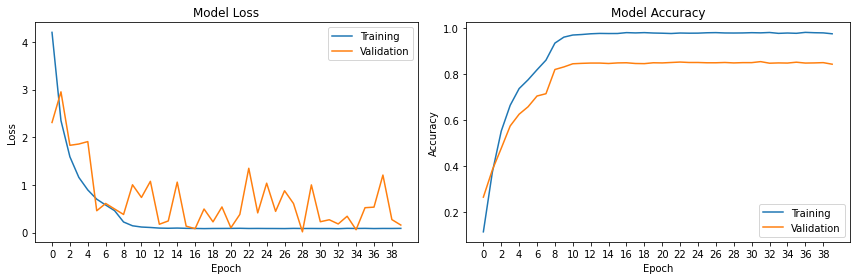

In [ ]:
plot_learning_curves(trainLoss2, trainAcc2, validLoss2, validAcc2)

# 4. Test models  
We only use the models that have been saved at highest validation accuracy. The reason is that extra training epoches 

In [ ]:
print('For Alexnet model:')
checkpoint1 = torch.load("alexnet_model.pt")
alexnet.load_state_dict(checkpoint1)
test_acc1, test_loss1 = eval_model(alexnet, criterion, 'test')

print('\nFor VGG model:')
checkpoint3 = torch.load("vgg19_model.pt")
vgg19.load_state_dict(checkpoint3)
test_acc3, test_loss3 = eval_model(vgg19, criterion, 'test')

print('\nFor Resnet model:')
checkpoint2 = torch.load("resnet34_model.pt")
resnet34.load_state_dict(checkpoint2)
test_acc2, test_loss2 = eval_model(resnet34, criterion, 'test')

For Alexnet model:
Accuracy of the network on the test images: 0.403 (2592/6433)

For VGG model:
Accuracy of the network on the test images: 0.801 (5154/6433)

For Resnet model:
Accuracy of the network on the test images: 0.846 (5441/6433)


### Evaluate the model on single images (e.g for production)   

In [ ]:
def get_results(models, images, labels):
    num = 8
    labels_str = [classes[x] for x in labels[:num]] 
    df = pd.DataFrame(columns=labels_str)
    index = []
    
    for model in models:
        index.append(model.__class__.__name__)
        model.eval()
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        softmax = torch.nn.functional.softmax(outputs, dim=1)
        conf, predicted = torch.max(softmax.data, 1)
        
        predicted = list(predicted.cpu().numpy())
        predicted = [classes[x] for x in predicted][:display_num]
        row_df = pd.DataFrame([predicted], columns=labels_str) 
        df = pd.concat([df, row_df])
    df.index = index
    return df

def apply_style(column):
    label = column.name
    red = 'color: red'
    green = 'color: green'
    return [red if val !=  label else green for val in column]

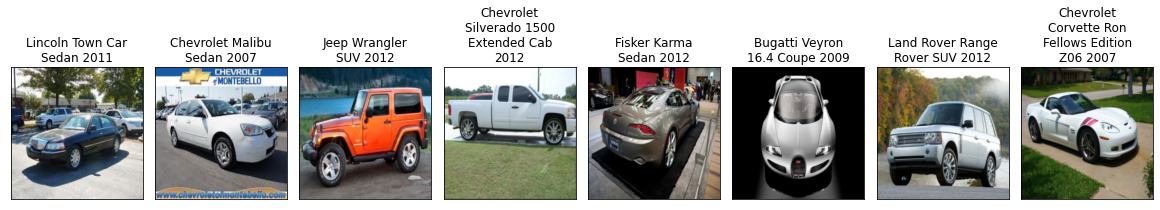

In [ ]:
display_num = 8

testiter = iter(test_loader)
test_images, test_labels = testiter.next()
display_images(test_images, test_labels, display_num)

In [ ]:
df = get_results([alexnet, resnet34, vgg19], test_images, test_labels)
df.style.apply(apply_style)

,Lincoln Town Car Sedan 2011,Chevrolet Malibu Sedan 2007,Jeep Wrangler SUV 2012,Chevrolet Silverado 1500 Extended Cab 2012,Fisker Karma Sedan 2012,Bugatti Veyron 16.4 Coupe 2009,Land Rover Range Rover SUV 2012,Chevrolet Corvette Ron Fellows Edition Z06 2007
AlexNet,Volvo 240 Sedan 1993,Chevrolet Malibu Sedan 2007,Jeep Wrangler SUV 2012,Ford F-150 Regular Cab 2007,Fisker Karma Sedan 2012,Bugatti Veyron 16.4 Convertible 2009,Land Rover Range Rover SUV 2012,Chevrolet Corvette Ron Fellows Edition Z06 2007
ResNet,Lincoln Town Car Sedan 2011,Chevrolet Malibu Sedan 2007,Jeep Wrangler SUV 2012,Chevrolet Silverado 1500 Extended Cab 2012,Fisker Karma Sedan 2012,Bugatti Veyron 16.4 Convertible 2009,Land Rover Range Rover SUV 2012,Chevrolet Corvette Ron Fellows Edition Z06 2007
VGG,Lincoln Town Car Sedan 2011,Chevrolet Malibu Sedan 2007,Jeep Wrangler SUV 2012,Chevrolet Silverado 1500 Extended Cab 2012,Fisker Karma Sedan 2012,Bugatti Veyron 16.4 Convertible 2009,Land Rover Range Rover SUV 2012,Chevrolet Corvette Ron Fellows Edition Z06 2007
